In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'read_nums_datasets',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

In [3]:
df_lrgasp = snakemake.params['df_lrgasp'].set_index('file_acc')

In [4]:
rows = list()

for i in snakemake.input['fastq_counts']:
    file_acc = Path(i).stem.split('_')[0]
    row = df_lrgasp.loc[file_acc]
    rows.append({
        'data source': f"{row['platform']}\n{row['library_prep']}",
        'count': int(open(i).read()),
        'read': 'total reads'
    })

for i in snakemake.input['bam']:
    file_acc = Path(i).stem.split('_')[0]
    row = df_lrgasp.loc[file_acc]
    print( f"{row['platform']}\n{row['library_prep']}", i, int(open(i).read()))
    rows.append({
        'data source': f"{row['platform']}\n{row['library_prep']}",
        'count': int(open(i).read()),
        'read': 'polyA usable reads'
    })

PacBio
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF105WIJ_bam.txt 3114603
PacBio
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF212HLP_bam.txt 3677979
PacBio
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF003QZT_bam.txt 4201924
ONT
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF654SNK_bam.txt 39866435
ONT
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF934KDM_bam.txt 27519715
ONT
CapTrap /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF104BNW_bam.txt 34812672
ONT
dRNA /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF155CFF_bam.txt 1233368
ONT
dRNA /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF771DIX_bam.txt 1782425
ONT
dRNA /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF600LIU_bam.txt 665771
PacBio
cDNA /home/cs/Projects/lapa/data/results/encode/read_count/ENCFF563QZR_bam.txt 3136976
PacBio
cDNA /home/cs/Projects/lapa/data/results/encode/rea

In [5]:
df = pd.DataFrame(rows).sort_values('data source')

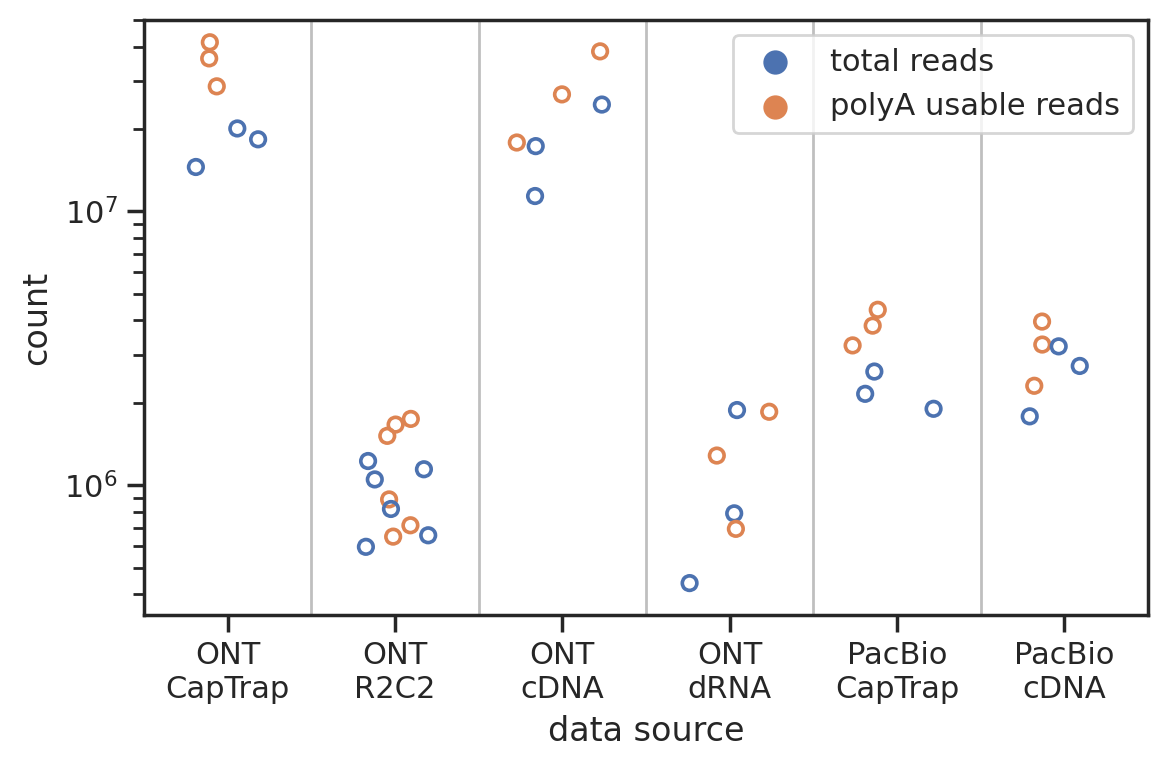

In [6]:
plt.figure(figsize=(6, 4), dpi=200)
ax = sns.stripplot(x='data source', y="count", hue="read", 
                   data=df, s=10, marker="$\circ$", jitter=0.3)
plt.yscale('log')
#plt.xticks(rotation=45)
plt.legend(title='')

for i in range(len(set(df['data source'])) - 1):
    ax.axvline(i + 0.5, color='grey', lw=1, alpha=0.5)

plt.tight_layout()
#plt.savefig(snakemake.output['read_nums'], bbox_inches = "tight")

In [3]:
df_short = pd.read_csv(snakemake.input['short_counts'])
df_short['data source'] = 'RNA-seq \n (gm12878)'

In [4]:
df_short = df_short.append({
    'type': 'merged-polyA',
    'count': df_short[df_short['type'] == 'polyA']['count'].sum(),
    'data source': 'rna-seq',
}, ignore_index=True).replace({'rna-seq': 'RNA-seq \n (gm12878)'})

In [5]:
df_quantseq = pd.read_csv(snakemake.input['quantseq'])
df_quantseq['data source'] = 'QuantSeq3 \n (gm12878)'

In [6]:
df_read3 = pd.read_csv(snakemake.input['read3'])
df_read3['data source'] = "3' READS \n (c2c12)"

In [7]:
df_c2c12 = pd.read_csv(snakemake.input['c2c12_read_annot'], sep='\t')

In [8]:
from collections import Counter

df_c2c12_long = pd.DataFrame({
    'type': ['raw'] * 4,
    'count': Counter(df_c2c12['dataset']).values(),
    'data source': 'PB LR-RNA-seq \n (c2c12)'
})

In [9]:
df_gm12 = pd.read_csv(snakemake.input['gm12878_read_annot'], sep='\t')
gm12_count = Counter(df_gm12['dataset'])

df_gm12878 = pd.DataFrame([{
        'type': 'raw',
        'count': count,
        'data source': '%s LR-RNA-seq \n (gm12878)' % label.split('_')[0]}
    for label, count in gm12_count.items()
])

In [10]:
df = pd.concat([
    df_quantseq,
    df_read3,
    df_short,
    df_c2c12_long,
    df_gm12878
], axis=0).rename(columns={'type': 'read'}).replace({'raw': 'all', 'polyA': 'polyA-tailed'})

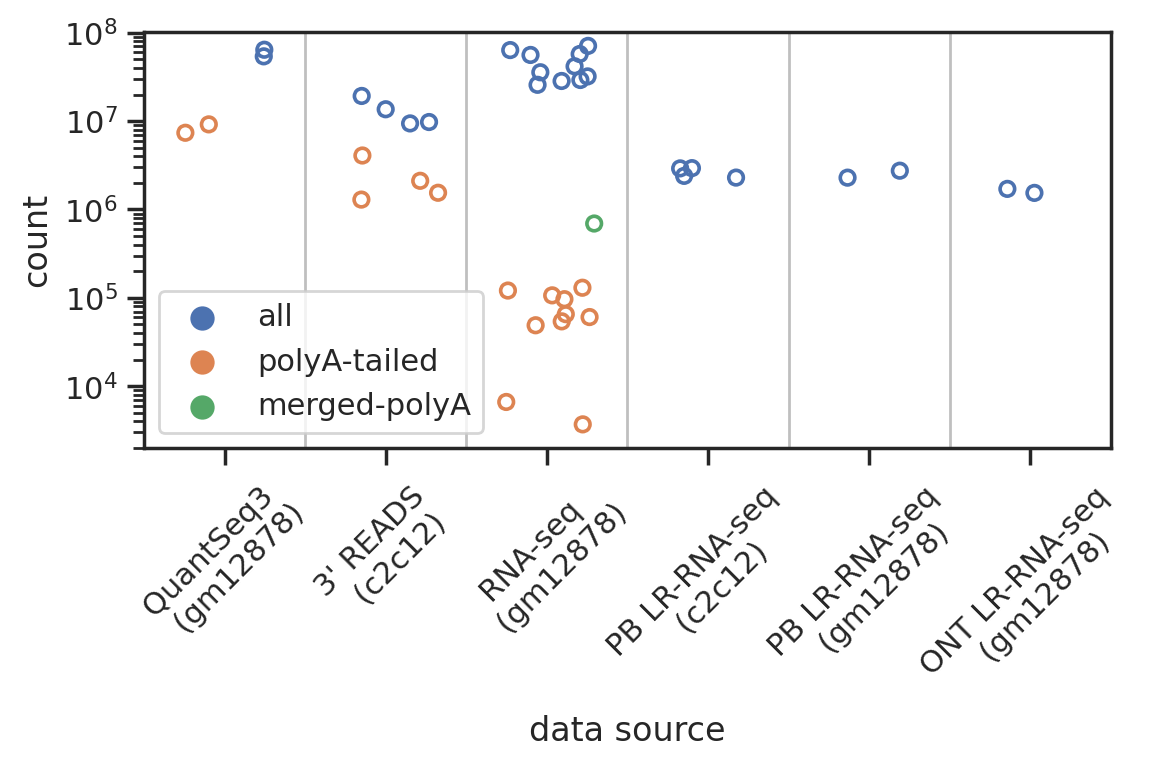

In [11]:
plt.figure(figsize=(6, 4), dpi=200)
ax = sns.stripplot(x='data source', y="count", hue="read", 
                   data=df, s=10, marker="$\circ$", jitter=0.3)
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='')

for i in range(len(set(df['data source'])) - 1):
    ax.axvline(i + 0.5, color='grey', lw=1, alpha=0.5)

plt.tight_layout()
plt.savefig(snakemake.output['read_nums'], bbox_inches = "tight")